In [36]:
'''
Kalyani Ramanan 8/1/25
This script is a debugging exercise for the retrieval code in Varon et al. (2021).

'''

'\nKalyani Ramanan 8/1/25\nThis script is a debugging exercise for the retrieval code in Varon et al. (2021).\n\n'

## Load and run retrieval functions


### Load libraries, set constants, paths, initial parameter definition

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy import optimize
from scipy import interpolate
import os
import ee
import geemap
from geemap import *
import numpy as np
import xarray as xr # May need to install using %pip install xarray
import datetime
from matplotlib import pyplot as plt

ee.Authenticate()

#Initialize earth engine for a new Python session
ee.Initialize(project = 'ee-krgeophys')



In [3]:
# Global variables
c = 299792458.
kB = 1.38064852e-23
deg = np.pi/180
mbartoatm = 0.000986923
kpatoatm = 0.00986923/1000.
kmtocm = 1E5
mtocm = 100.
mol=6.022140857E23
start_time = time.time()

# Key directories
aux_data_dir = 'aux_data'
hapi_data_dir = 'hapi_data'

In [4]:
# Initial parameter Configuration - can ovewrite later
nlayers = 100
num_layers = nlayers
targheight = 0
obsheight = 100
obsangle = 40
solarangle  = 0
instrument = 'S2A'
method = 'MBSP'

### Import mixing ratios, temp, press profiles

In [5]:
def importMRTP(num_layers, targheight, obsheight, solarangle, obsangle, ch4_scale=1.1029, co2_scale=1.2424, h2o_scale=1):
    '''
    Load auxiliary data for vertical profiles of temperature, pressure, and CH4, CO2, and H2O mixing ratio.
    These data come from the U.S. Standard Atmosphere. 
    Also calculate the pathlength in each layer for input observation angles.
    CH4 and CO2 profiles need to be scaled up to match modern-day concentrations.

    Arguments
        num_layers [int]   : Number of vertical pressure layers for the radiative transfer calculation
        targheight [float] : Target elevation above sea level in km
        obsheight  [float] : Altitude of satellite instrument in km. Can use 100 km as if satellite were at top of atmosphere
        solarangle [float] : Solar zenith angle in degrees
        obsangle   [float] : Viewing zenith angle of instrument in degrees
        ch4_scale  [float] : Scale factor multiplying U.S. Standard CH4 profile (1.1029 implies 1875 ppb at the surface)
        co2_scale  [float] : Same but for U.S. Standard CO2 profile (1.2424 implies 410 ppm at the surface)
        h2o_scale  [float] : Same but for U.S. Standard H2O profile

    Returns
        pathlength [float] : Path length in each layer [cm]
        pressavg   [float] : Average pressure in each layer [atm]
        tempavg    [float] : Average temperature in each layer [K]
        mrCH4avg   [float] : Average CH4 mixing ratio in each layer
        mrCO2avg   [float] : Average CO2 mixing ratio in each layer
        mrH2Oavg   [float] : Average H2O mixing ratio in each layer
    ''' 
        
    # Mixing Ratio
    
    mrCO2 = np.transpose(np.genfromtxt(f'{aux_data_dir}/co2.dat'))
    mrH2O = np.transpose(np.genfromtxt(f'{aux_data_dir}/h2o.dat'))
    mrCH4 = np.transpose(np.genfromtxt(f'{aux_data_dir}/ch4.dat'))
    # Temperature
    temp = np.transpose(np.genfromtxt(f'{aux_data_dir}/temperature.dat'))
    
    # Pressure
    press = np.transpose(np.genfromtxt(f'{aux_data_dir}/pressure.dat'))
    
    # Define altitude in cm
    altitude = press[1][::-1] * kmtocm
    # Define pressure in atm
    pressure = press[0][::-1] * mbartoatm
    
    # Find pressure as a function of altitude
    altfine = np.arange(0, 10, 0.01)
    pressfine = np.interp(altfine, press[1], press[0]*mbartoatm)
    idfine = (np.abs(altfine-targheight)).argmin()
    pressmax = pressfine[idfine]    
    
    # Interpolate to get layers evenly spaced in pressure
    dpress = (pressmax-2.9608E-5)/num_layers
    pressinterp = np.arange(0, pressmax+dpress, dpress)
    altinterp = np.interp(pressinterp, pressure, altitude)

    # Find temperature at each altitude
    alttemp = temp[1]*kmtocm
    temperature = temp[0]
    tempinterp = np.interp(altinterp, alttemp, temperature)
    
    # Find mixing ratios at each altitude
    altmrCH4 = mrCH4[1]*kmtocm
    altmrCO2 = mrCO2[1]*kmtocm
    altmrH2O = mrH2O[1]*kmtocm
    mixrateCH4 = mrCH4[0]*ch4_scale
    mixrateCO2 = mrCO2[0]*co2_scale
    mixrateH2O = mrH2O[0]*h2o_scale
    
    # Interpolate and then sample using the altitude sample points determined from isobaric pressure increases
    mrCH4interp = np.interp(altinterp, altmrCH4, mixrateCH4)
    mrCO2interp = np.interp(altinterp, altmrCO2, mixrateCO2)
    mrH2Ointerp = np.interp(altinterp, altmrH2O, mixrateH2O)
    
    def find_nearest_alt(array,value):
        idx = (np.abs(array-value)).argmin()
        secondpass = array[idx:len(array)]
        zeroarray = np.zeros(idx)
        upwellingpass = np.concatenate((zeroarray, secondpass))
        return upwellingpass
    
    upwellingpass = find_nearest_alt(altinterp, obsheight*kmtocm)
    
    # Find path length of each layer
    pathlengthdown = np.zeros(num_layers)
    pathlengthup = np.zeros(num_layers)
    for i in range(0, num_layers):
        pathlengthdown[i] = np.absolute(altinterp[i]-altinterp[i+1])
        pathlengthup[i] = np.absolute(upwellingpass[i]-upwellingpass[i+1])
        
    # Calculate path given the Solar and observation angle from Nadir
    pathlength = pathlengthdown/np.cos(solarangle*deg) + pathlengthup/np.cos(obsangle*deg)
 
    # Define average value in layers
    pressavg = np.zeros(len(pathlength))
    tempavg = np.zeros(len(pathlength))
    mrCH4avg = np.zeros(len(pathlength))
    mrCO2avg = np.zeros(len(pathlength))
    mrH2Oavg = np.zeros(len(pathlength))   
    for i in range(0,len(pathlength)):
        pressavg[i] = (pressinterp[i+1]+pressinterp[i])/2.
        tempavg[i] = (tempinterp[i+1]+tempinterp[i])/2.
        mrCH4avg[i] = (mrCH4interp[i+1]+mrCH4interp[i])/2.
        mrCO2avg[i] = (mrCO2interp[i+1]+mrCO2interp[i])/2.
        mrH2Oavg[i] = (mrH2Ointerp[i+1]+mrH2Ointerp[i])/2.

    return pathlength, pressavg, tempavg, mrCH4avg, mrCO2avg, mrH2Oavg

### Save toasr, ods, solar spec for each band/instrument combo

##### This is my modification to the original code. I have moved the interpolation and saving of optical depth solar spectrum and enhancement-free toasr out of the iteration to decrease run time

In [6]:
# Calculate and save optical densities

def save_optical_densities(instrument, band):

    # Load absorption cross-sections for S2A band 12

    wavelength = np.load(f'{hapi_data_dir}/abs_wave_hapi_{instrument}_band{band}.npy')
    press_load = np.load(f'{hapi_data_dir}/abs_press_hapi_{instrument}_band{band}.npy')
    temp_load = np.load(f'{hapi_data_dir}/abs_temp_hapi_{instrument}_band{band}.npy')   
    absCH4_load  = np.load(f'{hapi_data_dir}/abs_ch4_hapi_{instrument}_band{band}.npy')
    absCO2_load = np.load(f'{hapi_data_dir}/abs_co2_hapi_{instrument}_band{band}.npy')
    absH2O_load = np.load(f'{hapi_data_dir}/abs_h2o_hapi_{instrument}_band{band}.npy')
    num_wave = len(wavelength)

    # Calculate optical density
    odCH4pts_upper = np.zeros(num_wave)
    odCH4pts_lower = np.zeros(num_wave)
    odCO2pts = np.zeros(num_wave)
    odH2Opts = np.zeros(num_wave)


    interp_order = 3

    for i in range(num_wave):

        fCH4_tp = scipy.interpolate.RectBivariateSpline(temp_load, press_load, absCH4_load.T[i], kx=interp_order, ky=interp_order)
        fCO2_tp = scipy.interpolate.RectBivariateSpline(temp_load, press_load, absCO2_load.T[i], kx=interp_order, ky=interp_order)
        fH2O_tp = scipy.interpolate.RectBivariateSpline(temp_load, press_load, absH2O_load.T[i], kx=interp_order, ky=interp_order)
                # Get solar spectrum - also save since it changes for each band/instrument combo due to wavelength variable

        for j in range(num_layers):

            # Calculate density
            temperature_K = temp[j]
            pressure_atm = press_atm[j]
            pressure_Pa = pressure_atm*101325
            density_m3 = pressure_Pa/(kB*temperature_K)
            density_cm3 = density_m3/(1E6)

            # Evaluate interpolation function
            f_CH4_temp = fCH4_tp(temperature_K, pressure_atm)
            f_CO2_temp = fCO2_tp(temperature_K, pressure_atm)
            f_H2O_temp = fH2O_tp(temperature_K, pressure_atm)
                        
            # Calculate the (unit-less) optical density: OD = abs*n*MR*L
            lim_low = 6
            if j >= num_layers - lim_low:
                # Lowest 6 pressure layers = lowest 500 m of atmosphere (lower)
                odCH4pts_lower[i] = odCH4pts_lower[i] + f_CH4_temp*density_cm3*mrCH4[j]*L_cm[j]
            else:
                # The rest of the atmosphere (upper)
                odCH4pts_upper[i] = odCH4pts_upper[i] + f_CH4_temp*density_cm3*mrCH4[j]*L_cm[j]
            odCO2pts[i] = odCO2pts[i] + f_CO2_temp*density_cm3*mrCO2[j]*L_cm[j]
            odH2Opts[i] = odH2Opts[i] + f_H2O_temp*density_cm3*mrH2O[j]*L_cm[j]




    # Save optical densities
    
    # Create the directory if it doesn't exist
    directory = "optical_densities"
    if not os.path.exists(directory):
        os.makedirs(directory)

   # Save the variables to  .npy files
    np.save(os.path.join(directory, f"odCH4pts_upper_{instrument}_{band}.npy"), odCH4pts_upper)
    np.save(os.path.join(directory, f"odCH4pts_lower_{instrument}_{band}.npy"), odCH4pts_lower)
    np.save(os.path.join(directory, f"odH2Opts_{instrument}_{band}.npy"), odH2Opts)
    np.save(os.path.join(directory, f"odCO2pts_{instrument}_{band}.npy"), odCO2pts)


In [7]:
# Generate and save optical densities for S2A and S2B bands 11 and 12

instruments = ['S2A', 'S2B']
bands = ['11', '12']

# Don't run if files have already been saved
if not os.path.exists('optical_densities/odCH4pts_upper_S2A_12.npy'):
    
    for instrument in instruments:
        for band in bands:
            save_optical_densities(instrument, band)


In [8]:
directory_solar = "solar_spectra"

In [9]:
# Generate solar spectrum for each instrument/band combo


def save_solar_spec(instrument, band):

    wavelength = np.load(f'{hapi_data_dir}/abs_wave_hapi_{instrument}_band{band}.npy')

    # Get solar spectrum - also save since it changes for each band/instrument combo due to wavelength variable
    solarspec = np.transpose(np.genfromtxt(f'{aux_data_dir}/SUNp01_4000_to_7000.txt'))
    wavesolar = 1E7/solarspec[0][::-1]
    radiancesolar = solarspec[1][::-1]*(100*solarspec[0][::-1]**2)

    solarradiance = np.interp(wavelength, wavesolar,radiancesolar)

    # directory_solar = "solar_spectra"
    # if not os.path.exists(directory_solar):
    #     os.makedirs(directory_solar)

    np.save(os.path.join(directory_solar, f"solar_spectrum_{instrument}_{band}.npy"), solarradiance)

In [10]:
# Generate solar spectrum for each instrument/band combo


def save_solar_spec(instrument, band):

    wavelength = np.load(f'{hapi_data_dir}/abs_wave_hapi_{instrument}_band{band}.npy')

    # Get solar spectrum - also save since it changes for each band/instrument combo due to wavelength variable
    solarspec = np.transpose(np.genfromtxt(f'{aux_data_dir}/SUNp01_4000_to_7000.txt'))
    wavesolar = 1E7/solarspec[0][::-1]
    radiancesolar = solarspec[1][::-1]*(100*solarspec[0][::-1]**2)

    solarradiance = np.interp(wavelength, wavesolar,radiancesolar)

    # directory_solar = "solar_spectra"
    # if not os.path.exists(directory_solar):
    #     os.makedirs(directory_solar)

    np.save(os.path.join(directory_solar, f"solar_spectrum_{instrument}_{band}.npy"), solarradiance)

In [11]:
# Generate and save optical densities for S2A and S2B bands 11 and 12

instruments = ['S2A', 'S2B']
bands = ['11', '12']

for instrument in instruments:
    for band in bands:
        save_solar_spec(instrument, band)
        print(f'{instrument} band {band} solar spectrum saved.')


S2A band 11 solar spectrum saved.
S2A band 12 solar spectrum saved.
S2B band 11 solar spectrum saved.
S2B band 12 solar spectrum saved.


In [12]:

def save_toasr(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=nlayers):

    # Import press, temp, pathlength and mixing ratios using ImportMRTP function
    # Import pressure, temperature, path-length, and mixing ratios
    (L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)

    # Calculate slant column density of methane
    cdCH4 = np.sum((press_atm/kpatoatm/(kB*temp)/mtocm**3)*mrCH4*L_cm/mol*mtocm**2)

    lim_low = 6
    
    press_atm_lower = press_atm[-lim_low:]
    temp_lower = temp[-lim_low:]
    L_cm_lower = L_cm[-lim_low:]
    cdCH4_lower = np.sum((press_atm_lower/kpatoatm/(kB*temp_lower)/mtocm**3)*mrCH4[-lim_low:]*L_cm_lower/mol*mtocm**2)

    # Load optical densities
    solarradiance = np.load(f'solar_spectra/solar_spectrum_{instrument}_{band}.npy')
    odCH4pts_lower = np.load(f'optical_densities/odCH4pts_lower_{instrument}_{band}.npy')
    odCO2pts = np.load(f'optical_densities/odCO2pts_{instrument}_{band}.npy')
    odCH4pts_upper = np.load(f'optical_densities/odCH4pts_upper_{instrument}_{band}.npy') 
    odH2Opts = np.load(f'optical_densities/odH2Opts_{instrument}_{band}.npy')     
    
    # Calculate the Top-Of-Atmosphere Spectral Radiance (TOASR) in the band [W/m2/m/sr]
    solar_spectrum = solarradiance/np.pi * np.cos(solarangle*deg)
    toasr = np.mean(np.exp(-(odCH4pts_lower + odCH4pts_upper + odCO2pts + odH2Opts)) * solar_spectrum)

    # save toasr 
    directory_toasr = "standard_toasr"
    if not os.path.exists(directory_toasr):
        os.makedirs(directory_toasr)

    np.save(os.path.join(directory_toasr, f"solar_spectrum_{instrument}_{band}.npy"), solarradiance)
    np.save(f'toasr_{instrument}_{band}.npy', toasr)





In [13]:
def save_toasr(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=100):

    # Import press, temp, pathlength and mixing ratios using ImportMRTP function
    # Import pressure, temperature, path-length, and mixing ratios
    (L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)

    # Calculate slant column density of methane
    cdCH4 = np.sum((press_atm/kpatoatm/(kB*temp)/mtocm**3)*mrCH4*L_cm/mol*mtocm**2)

    lim_low = 6
    
    press_atm_lower = press_atm[-lim_low:]
    temp_lower = temp[-lim_low:]
    L_cm_lower = L_cm[-lim_low:]
    cdCH4_lower = np.sum((press_atm_lower/kpatoatm/(kB*temp_lower)/mtocm**3)*mrCH4[-lim_low:]*L_cm_lower/mol*mtocm**2)

    # Load optical densities
    solarradiance = np.load(f'solar_spectra/solar_spectrum_{instrument}_{band}.npy')
    odCH4pts_lower = np.load(f'optical_densities/odCH4pts_lower_{instrument}_{band}.npy')
    odCO2pts = np.load(f'optical_densities/odCO2pts_{instrument}_{band}.npy')
    odCH4pts_upper = np.load(f'optical_densities/odCH4pts_upper_{instrument}_{band}.npy') 
    odH2Opts = np.load(f'optical_densities/odH2Opts_{instrument}_{band}.npy')     
    
    # Calculate the Top-Of-Atmosphere Spectral Radiance (TOASR) in the band [W/m2/m/sr]
    solar_spectrum = solarradiance/np.pi * np.cos(solarangle*deg)
    toasr = np.mean(np.exp(-(odCH4pts_lower + odCH4pts_upper + odCO2pts + odH2Opts)) * solar_spectrum)

    # save toasr 
    # directory_toasr = "standard_toasr"
    # if not os.path.exists(directory_toasr):
          # os.makedirs(directory_toasr)

    np.save(os.path.join(directory_toasr, f"toasr_{instrument}_{band}.npy"), toasr)
    np.save(f'toasr_{instrument}_{band}.npy', toasr)


In [14]:
directory_toasr = "standard_toasr"

In [15]:
# Generate and save toasr for S2A and S2B bands 11 and 12

instruments = ['S2A', 'S2B']
bands = ['11', '12']

for instrument in instruments:
    for band in bands:
        save_toasr(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=nlayers)
        print(f'toasr_{instrument} band {band} saved.')

toasr_S2A band 11 saved.
toasr_S2A band 12 saved.
toasr_S2B band 11 saved.
toasr_S2B band 12 saved.


### Define radiative transfer equation

In [16]:
def radtran(targheight, obsheight, solarangle, obsangle, instrument, band, num_layers=nlayers):

    # Import press, temp, pathlength and mixing ratios using ImportMRTP function
    # Import pressure, temperature, path-length, and mixing ratios
    (L_cm, press_atm, temp, mrCH4, mrCO2, mrH2O) = importMRTP(num_layers, targheight, obsheight, solarangle, obsangle)

    # Calculate slant column density of methane
    cdCH4 = np.sum((press_atm/kpatoatm/(kB*temp)/mtocm**3)*mrCH4*L_cm/mol*mtocm**2)

    lim_low = 6
    
    press_atm_lower = press_atm[-lim_low:]
    temp_lower = temp[-lim_low:]
    L_cm_lower = L_cm[-lim_low:]
    cdCH4_lower = np.sum((press_atm_lower/kpatoatm/(kB*temp_lower)/mtocm**3)*mrCH4[-lim_low:]*L_cm_lower/mol*mtocm**2)

    # Load optical densities
    solarradiance = np.load(f'solar_spectra/solar_spectrum_{instrument}_{band}.npy')
    odCH4pts_lower = np.load(f'optical_densities/odCH4pts_lower_{instrument}_{band}.npy')
    odCO2pts = np.load(f'optical_densities/odCO2pts_{instrument}_{band}.npy')
    odCH4pts_upper = np.load(f'optical_densities/odCH4pts_upper_{instrument}_{band}.npy') 
    odH2Opts = np.load(f'optical_densities/odH2Opts_{instrument}_{band}.npy')     
    
    # Calculate the Top-Of-Atmosphere Spectral Radiance (TOASR) in the band [W/m2/m/sr]
    solar_spectrum = solarradiance/np.pi * np.cos(solarangle*deg)
    toasr = np.mean(np.exp(-(odCH4pts_lower + odCH4pts_upper + odCO2pts + odH2Opts)) * solar_spectrum)

    # return toasr
    return toasr, odCH4pts_lower, odCH4pts_upper, odCO2pts, odH2Opts, solar_spectrum, cdCH4, cdCH4_lower



In [17]:
def retrieve(frac_refl_data, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=nlayers):
    '''
    Infer methane column enhancements from fractional reflectance measurements.

    Arguments
        frac_refl_data [float] : Array of fractional reflectance data, deltaR = (cR-R0)/R0
                                 e.g., DeltaR_SBMP from eq. (1) in Varon et al. 2021 AMT
        instrument     [str]   : MSI instrument. Choose 'S2A' or 'S2B'
        method         [str]   : Retrieval method corresponding to frac_refl_data
                                 Choose 'MBSP' or 'SBMP'
        targheight     [float] : Target elevation above sea level in km
        obsheight      [float] : Altitude of satellite instrument in km. Can use 100 km as if satellite were at top of atmosphere
        solarangle     [float] : Solar zenith angle in degrees
        obsangle       [float] : Viewing zenith angle of instrument in degrees
        num_layers     [int]   : Number of vertical pressure layers for the radiative transfer calculation
    '''

    # Get toasr, optical depths, etc. from radtran()
    toasr_11, odCH4_lower_11, odCH4_upper_11, odCO2_11, odH2O_11, solar_spectrum_11, _, _ = radtran(targheight, obsheight, solarangle, obsangle, instrument, band=11, num_layers=num_layers)
    toasr_12, odCH4_lower_12, odCH4_upper_12, odCO2_12, odH2O_12, solar_spectrum_12, cdCH4, cdCH4_lower = radtran(targheight, obsheight, solarangle, obsangle, instrument, band=12, num_layers=num_layers)
    
    def frac_abs_MBSP_difference(ch4_enh, data):
        '''
        Fractional absorption model to compare with measurements for MBSP method.
        
        Arguments
            ch4_enh [float] : Modeled enhancement as fraction of background
            data    [float] : Actual (cR-R0)/R0
        '''
            
        ch4 = ch4_enh + 1
        toasr_CH4enh_12 = np.mean(np.exp(-(ch4*odCH4_lower_12 + odCH4_upper_12 + odCO2_12 + odH2O_12))*solar_spectrum_12)
        toasr_CH4enh_11 = np.mean(np.exp(-(ch4*odCH4_lower_11 + odCH4_upper_11 + odCO2_11 + odH2O_11))*solar_spectrum_11)

        frac_abs_12 = (toasr_CH4enh_12 - toasr_12)/toasr_12
        frac_abs_11 = (toasr_CH4enh_11 - toasr_11)/toasr_11
        
        frac_abs_MBSP = frac_abs_12 - frac_abs_11 
            
        return frac_abs_MBSP - data


     
    start_time = time.time()

    # Do retrieval
    (num_rows, num_cols) = frac_refl_data.shape
    ch4_out = np.zeros((num_rows, num_cols))

    # add in counter
    count = 0

    for i in range(num_rows):
        for j in range(num_cols):

            data_temp = frac_refl_data[i,j]
                
            if np.isnan(data_temp):
                print('Found nan, skipping.')
                ch4_out[i,j] = np.nan
            
            # Solve for the best-fit fractional column (fraction of background)
            else:
                if method == 'SBMP':
                    ch4_temp = scipy.optimize.newton(lambda ch4_scale: frac_abs_SBMP_difference(ch4_scale,data_temp), 0, rtol=0.0001, maxiter=10000, disp=False)
                elif method == 'MBSP':
                    ch4_temp = scipy.optimize.newton(lambda ch4_scale: frac_abs_MBSP_difference(ch4_scale,data_temp), 0, rtol=0.0001, maxiter=10000, disp=False)
                    

                # Convert the fractional column to absolute vertical column density in mol/m2   
                AMF = 1/np.cos(obsangle*deg) + 1/np.cos(solarangle*deg)
                ch4_out[i,j] = ch4_temp * (cdCH4_lower/cdCH4)*(cdCH4/AMF)
                count = count + 1 
        
    # Time    
    print("--- %s seconds --- to optimize" % (time.time() - start_time))
    print(count)

    return ch4_out

## Check linear regression scaling factor
##### This number should be scaling B12 data so that it has the same mean radiance value across the scene as B11. Check whether this is the case

### Load the image data

In [37]:
# Load the GEE image which contains all bands of data for pass of 20/11/2019
img = ee.Image('COPERNICUS/S2_HARMONIZED/20191120T101321_20191120T101408_T31SGR')

In [ ]:

# Configure parameters for retrieval
nlayers = 100
targheight = 0 # elevation of target above sea level
obsheight = 100 # elevation of satellite above sea level in km
obsangle = img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B12').getInfo() # instrument observing angle in degrees, from image meatadata
solarangle = img.get('MEAN_SOLAR_ZENITH_ANGLE').getInfo() # solar zenith angle in degrees, from image meatadata
method = 'MBSP' # select retrieval method

# Get instrument from metadata (S2A or S2B)
if img.get('SPACECRAFT_NAME').getInfo() == 'Sentinel-2A':
    instrument = 'S2A'
    print('instrument is S2A')
elif img.get('SPACECRAFT_NAME').getInfo() == 'Sentinel-2B':
     instrument = 'S2B'
     print('instrument is S2B')
else:
    print('Instrument not recognized.')
    

instrument is S2A


In [20]:

# Test retrieval
ch4_out = retrieve(np.array([[-0.2, -0.1, -0.22], [-0.22, -0.13, -0.2],[-0.12, -0.23, -0.22]]), instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=100)
ch4_out

--- 0.006998538970947266 seconds --- to optimize
9


array([[6.38803169, 2.0935019 , 7.79114561],
       [7.79114561, 3.05169707, 6.38803169],
       [2.70901561, 8.60737979, 7.79114561]])

### Define region of interest (roi)

In [21]:
# Define geometry as rectangle with coordinates at 2km distance from source (found using google maps)
source_lat = 31.6585
source_lon = 5.9053
lonmin = 5.88419
lonmax = 5.92609
latmin = 31.64011
latmax = 31.67640

# Define GEE geometry shape over this area
geometry_area = ee.Geometry.Rectangle([lonmin, latmin, lonmax, latmax], None, False)

### Plot B12 and B11 toasr for this image over roi

In [22]:
### Plot  B12 TOASR over scene

B12 = img.select('B12').divide(10000).clip(geometry_area)
# Plot only B12 to see plume as show in Varon (2021) Figure 2b
mapB12 = geemap.Map()
# Define visualisation parameters
vis = {
    'min': 0.35,
    'max': 0.75,   
    'bands': ['B12']
   
}

mapB12.setCenter(source_lon, source_lat, 13.5) # Define map centre
mapB12.addLayer(img.divide(10000), vis, 'Sentinel-2') # Add bands of Sentinel-2 data
# Map.addLayer(geometry_area, {}, 'geometry_area') # Overlay rectangle used in Varon (2021) figure 2e
# Map.remove_colorbar(clear)
mapB12.add_colorbar(vis, label='TOA Refelctance')

mapB12

Map(center=[31.6585, 5.9053], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [23]:
# Plot B11
B11 = img.select('B11').divide(10000).clip(geometry_area)   
mapB11 = geemap.Map()
# Define visualisation parameters
vis = {
    'min': 0.35,
    'max': 0.75,   
    'bands': ['B11']
   
}
mapB11.setCenter(source_lon, source_lat, 13.5) # Define map centre
mapB11.addLayer(img.divide(10000), vis, 'Sentinel-2') # Add bands of Sentinel-2 data
# Map.addLayer(geometry_area, {}, 'geometry_area') # Overlay rectangle used in Varon (2021) figure 2e
# Map.remove_colorbar(clear)
mapB11.add_colorbar(vis, label='TOA Refelctance')

mapB11

Map(center=[31.6585, 5.9053], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### Get least squares fitting of B12 against B11 across the scene (Varon 2021)

In [24]:
# Use imRegress linearRegression to do regression of B11 and B12
imRegress = ee.Image.cat(B11, B12)

linearRegression = imRegress.reduceRegion(
    reducer = ee.Reducer.linearRegression(numX = 1, numY = 1),
    geometry = geometry_area,
    scale = 20,
)

c = linearRegression.get('coefficients').getInfo()[0][0]
print('Linear regression coefficients:', c)

Linear regression coefficients: 0.8682509285575256


#### Plot scaled B12 against B12 and B11


In [25]:
### Plot scaled B12 TOASR over scene

B12 = img.select('B12').divide(10000).clip(geometry_area)
# Plot only B12 to see plume as show in Varon (2021) Figure 2b
mapB12 = geemap.Map()
# Define visualisation parameters
vis = {
    'min': 0.35,
    'max': 0.75,   
    'bands': ['B12']
   
}

mapB12.setCenter(source_lon, source_lat, 13.5) # Define map centre
mapB12.addLayer(img.divide(10000).multiply(c), vis, 'Sentinel-2') # Add bands of Sentinel-2 data
# Map.addLayer(geometry_area, {}, 'geometry_area') # Overlay rectangle used in Varon (2021) figure 2e
# Map.remove_colorbar(clear)
mapB12.add_colorbar(vis, label='TOA Refelctance')

mapB12

Map(center=[31.6585, 5.9053], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

In [26]:
cB12 = B12.multiply(c)

In [27]:
# Layer B11, B12 and cB12 on map, can select layers to view
map_combined = geemap.Map()

# Define visualization parameters for B12
vis_params_B12 = {
    'min': 0.35,
    'max': 0.75,
    'bands': ['B12']
}

# Add B12 layer
map_combined.addLayer(B12, vis_params_B12, 'B12')

# Define visualization parameters for B11
vis_params_B11 = {
    'min': 0.35,
    'max': 0.75,
    'bands': ['B11']
}

# Add B11 layer
map_combined.addLayer(B11, vis_params_B11, 'B11')

# Add scaled B12 layer
map_combined.addLayer(cB12, vis_params_B12, 'Scaled B12')

# Set map center and zoom level
map_combined.setCenter(source_lon, source_lat, 13.5)

# Display the map
map_combined
map_combined.addLayerControl()
display(map_combined)

Map(center=[31.6585, 5.9053], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### Do the same for c calculated the other way (c = 1.15) - THIS WORKS

In [28]:
# Use imRegress linearRegression to do regression of B11 and B12
imRegress = ee.Image.cat(B12, B11)

linearRegression = imRegress.reduceRegion(
    reducer = ee.Reducer.linearRegression(numX = 1, numY = 1),
    geometry = geometry_area,
    scale = 20,
)

c = linearRegression.get('coefficients').getInfo()[0][0]
print('Linear regression coefficients:', c)

Linear regression coefficients: 1.1512279743749336


In [29]:
cB12 = B12.multiply(c)

In [30]:
# Layer B11, B12 and cB12 on map, can select layers to view
map_combined = geemap.Map()

# Define visualization parameters for B12
vis_params_B12 = {
    'min': 0.35,
    'max': 0.75,
    'bands': ['B12']
}

# Add B12 layer
map_combined.addLayer(B12, vis_params_B12, 'B12')

# Define visualization parameters for B11
vis_params_B11 = {
    'min': 0.35,
    'max': 0.75,
    'bands': ['B11']
}

# Add B11 layer
map_combined.addLayer(B11, vis_params_B11, 'B11')

# Add scaled B12 layer
map_combined.addLayer(cB12, vis_params_B12, 'Scaled B12')

# Set map center and zoom level
map_combined.setCenter(source_lon, source_lat, 13.5)

# Display the map
map_combined
map_combined.addLayerControl()
display(map_combined)

Map(center=[31.6585, 5.9053], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### scatter plot B12 against B11

In [31]:
# Get B12 and B11 data from images to numpy arrays

# Define the region of interest (roi)
roi = geometry_area

# Get the B12 band values as a list of dictionaries
b12_values_list = B12.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi,
    scale=20
).get('B12').getInfo()

# Convert the list to a NumPy array
b12_values_array = np.array(b12_values_list)

print(b12_values_array)

# Get the B11 band values as a list of dictionaries
b11_values_list = B11.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=roi,
    scale=20
).get('B11').getInfo()

# Convert the list to a NumPy array
b11_values_array = np.array(b11_values_list)

print(b11_values_array)

[0.54119998 0.5345     0.53509998 ... 0.49529999 0.4948     0.49680001]
[0.6038     0.59609997 0.5977     ... 0.58450001 0.58340001 0.5862    ]


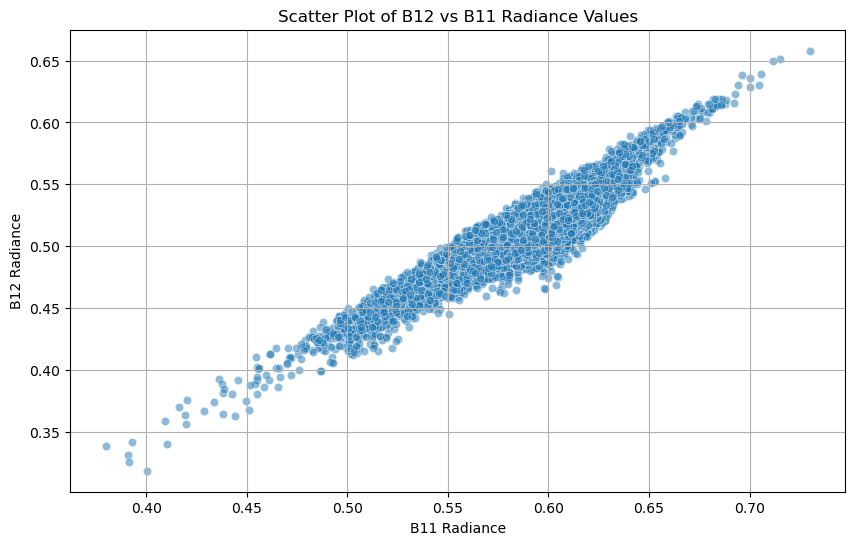

In [32]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(b11_values_array, b12_values_array, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.xlabel('B11 Radiance')
plt.ylabel('B12 Radiance')
plt.title('Scatter Plot of B12 vs B11 Radiance Values')
plt.grid(True)
plt.show()

## Check whether changing c from 0.86 to 1.15 gets the correct retrieval result

In [33]:
# Use image.expression() to write equation for R_MBSP
R_MBSP = img.expression(
    '(((c*R12) - R11))/(R11) ', # Where this number comes from least squares difference scale above
    {
        
        # 'c': linearRegression.get('coefficients').getInfo()[0],
        'c': c, 
        'R11': img.select('B11').divide(10000),
        'R12': img.select('B12').divide(10000),
    },
)

# Methane column enhancement in ppm
# F_MBSP = R_MBSP.subtract(-0.029)
F_MBSP = R_MBSP

F_MBSP_array = np.array(F_MBSP.sampleRectangle(geometry_area).get('constant').getInfo())

In [34]:
# Do retrieval

ch4_enh = retrieve(F_MBSP_array, 'S2A', method, targheight, obsheight, solarangle, obsangle, num_layers=200)
ch4_enh

--- 17.399238109588623 seconds --- to optimize
42640


array([[-0.10235906, -0.07344855, -0.10304366, ..., -0.10712428,
        -0.0302958 , -0.0732964 ],
       [ 0.02068364, -0.03550533, -0.11934089, ...,  0.05628551,
        -0.09738845, -0.03907811],
       [-0.03296966, -0.11418207, -0.01183375, ...,  0.12185087,
         0.04893532,  0.02796768],
       ...,
       [-0.03535918,  0.01932386,  0.08555912, ..., -0.06119116,
        -0.10594596, -0.00654024],
       [-0.02866815, -0.02014293,  0.01968059, ...,  0.08969418,
         0.15535039, -0.04500909],
       [ 0.02984741, -0.01729327, -0.00235232, ...,  0.02688544,
        -0.15896473, -0.19640843]])

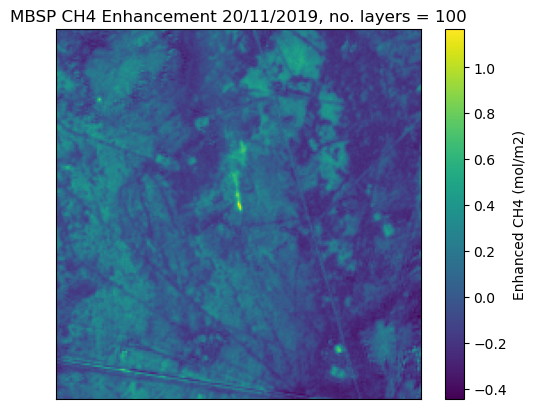

In [35]:
# Plot map of methane enhancement

import matplotlib.pyplot as plt

plt.imshow(ch4_enh, cmap='viridis')

plt.title('Enhanced CH4 2D Image Plot')
import matplotlib.pyplot as plt

# plt.imshow(ch4_enh, cmap='viridis',vmin =  -2, vmax= 2)
# plt.imshow(ch4_enh, cmap='viridis')
fig1 = plt.imshow(ch4_enh, cmap='viridis') #vmin = minval, vmax = maxval)
plt.colorbar(label='Enhanced CH4 (mol/m2)')
plt.title(f'MBSP CH4 Enhancement 20/11/2019, no. layers = {nlayers}')
plt.xticks([])
plt.yticks([])
plt.show()